In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import urljoin

In [5]:
def get_noticias(url, keywords):
    """
    Função que coleta notícias de uma página específica baseada em palavras-chave nos links.
    Também coleta a data de publicação, se disponível.
    """
    noticias = []
    response = requests.get(url)
    response.encoding = response.apparent_encoding  # Ajuste para decodificação correta
    soup = BeautifulSoup(response.content, "html.parser")

    # Encontrar todos os links na página
    links = soup.find_all('a', href=True)

    # Filtrar e armazenar apenas os links que contêm as palavras-chave
    for link_tag in links:
        link = link_tag['href']
        title = link_tag.get_text(strip=True)
        
        # Verificar se a palavra-chave está no link ou no título
        if any(keyword in link.lower() for keyword in keywords):
            # Se o link não é absoluto, fazê-lo absoluto
            if not link.startswith('http'):
                link = urljoin(url, link)

            # Tentar capturar a data de publicação da notícia
            try:
                # Exemplos genéricos: ajuste conforme a estrutura do site
                date_tag = soup.find('time')  # Se houver uma tag <time> na página
                if date_tag and date_tag.has_attr('datetime'):
                    date = date_tag['datetime']
                else:
                    # Tentativa alternativa, por exemplo, se a data estiver em um <span> com uma classe específica
                    date_tag = soup.find('span', class_='data-publicacao')
                    date = date_tag.get_text(strip=True) if date_tag else 'Data não disponível'
            except Exception as e:
                date = 'Data não disponível'

            # Adicionar a notícia à lista, incluindo a data
            if title:
                noticias.append({"title": title, "link": link, "date": date})
    
    return noticias

def crawl_site(url, base_url, keywords, depth=3):
    """
    Função recursiva para percorrer todo o site, coletando notícias relevantes.
    Agora coleta a data da notícia.
    """
    visited_links = set()
    noticias = []

    def _crawl(url, current_depth):
        # Verificar se o link já foi visitado ou se a profundidade máxima foi atingida
        if current_depth == 0 or url in visited_links:
            return
        
        visited_links.add(url)  # Marcar o link como visitado
        noticias_atual = get_noticias(url, keywords)

        # Remover links duplicados antes de adicionar à lista de notícias
        for noticia in noticias_atual:
            if noticia["link"] not in {n["link"] for n in noticias}:
                noticias.append(noticia)

        response = requests.get(url)
        response.encoding = response.apparent_encoding
        soup = BeautifulSoup(response.content, "html.parser")

        # Encontrar todos os links na página e seguir
        links = soup.find_all('a', href=True)

        for link_tag in links:
            link = link_tag['href']
            if not link.startswith('http'):
                link = urljoin(base_url, link)

            # Verificar se o link é interno e não foi visitado
            if base_url in link and link not in visited_links:
                _crawl(link, current_depth - 1)

    _crawl(url, depth)
    return noticias

def plot_keyword_distribution(df, keyword, color):
    filtered_df = df[df['title'].str.contains(keyword, case=False, na=False)]
    site_counts = filtered_df['Site'].value_counts()

    plt.figure(figsize=(10, 6))
    site_counts.plot(kind='bar', color=color)
    plt.title(f'Número de Links por Site Contendo "{keyword}"')
    plt.xlabel('Site')
    plt.ylabel('Número de Links')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [6]:
base_url = "https://www1.folha.uol.com.br/equilibrioesaude/"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias do site inteiro, seguindo links internos
noticias_folha = crawl_site(base_url, base_url, keywords, depth=3)

# Converter a lista de notícias em um DataFrame do pandas
df_folha = pd.DataFrame(noticias_folha)

# Remover títulos duplicados
df_folha = df_folha.drop_duplicates(subset='title')

df_folha['Site'] = 'Folha'

# Exibir o DataFrame filtrado
df_folha

,title,link,date,Site
0,Tire dúvidas sobre a vacinação de crianças con...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
1,Pais que não vacinam filhos podem até perder a...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
2,Rio amplia vacina da Covid adaptada contra nov...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
3,Ministério da Saúde negocia aquisição de 25 mi...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
4,Vírus da Covid usa máquina celular para escapa...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
...,...,...,...,...
137,sintomas neurológicos,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-07 07:00:00,Folha
139,sistema nervoso central,https://www1.folha.uol.com.br/cotidiano/2021/0...,2024-08-07 07:00:00,Folha
140,sistema nervoso,https://agora.folha.uol.com.br/sao-paulo/2021/...,2024-08-07 07:00:00,Folha
141,Covid longa,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-07 07:00:00,Folha


In [7]:
base_url1 = 'https://g1.globo.com/fato-ou-fake/'

noticias_g1 = crawl_site(base_url1, base_url1, keywords, depth=3)

df_g1 = pd.DataFrame(noticias_g1)

df_g1['Site'] = 'Fato ou fake (G1)'

df_g1

,title,link,date,Site
0,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1)
1,É #FAKE que o Brasil é o único país a exigir v...,https://g1.globo.com/fato-ou-fake/noticia/2024...,Data não disponível,Fato ou fake (G1)


In [8]:
base_url2 = 'https://www.gov.br/saude/pt-br'

noticias_gov = crawl_site(base_url2, base_url2, keywords, depth=3)

df_gov = pd.DataFrame(noticias_gov)

df_gov['Site'] = 'gov.br saude'

df_gov

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


,title,link,date,Site
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,gov.br saude
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,gov.br saude
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,gov.br saude
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,gov.br saude
...,...,...,...,...
346,Raíssa Machado,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude
347,Margareth Dalcolmo,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude
348,Acesse as Peças do Movimento Nacional pela Va...,https://www.gov.br/saude/pt-br/campanhas-da-sa...,Data não disponível,gov.br saude
349,Acesse para saber como emitir o Certificado Na...,https://www.gov.br/pt-br/servicos/certificado-...,Data não disponível,gov.br saude


In [9]:
base_url3 = 'https://www.aosfatos.org'

noticias_aosfatos = crawl_site(base_url3, base_url3, keywords, depth=3)

df_aosfatos = pd.DataFrame(noticias_aosfatos)

df_aosfatos['Site'] = 'Aos Fatos'

df_aosfatos

,title,link,date,Site
0,Para que serve e quem pode tomar a vacina cont...,https://www.aosfatos.org/noticias/para-que-ser...,Data não disponível,Aos Fatos
1,entrou com uma ação,https://www.aosfatos.org/bipe/agu-acao-telegra...,Data não disponível,Aos Fatos
2,nesta quinta-feira (25),https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,Aos Fatos
3,5 milhões em 2024,https://www.gov.br/saude/pt-br/assuntos/notici...,Data não disponível,Aos Fatos
4,lista de municípios,https://www.gov.br/saude/pt-br/assuntos/saude-...,Data não disponível,Aos Fatos
5,Folha de S.Paulo,https://www1.folha.uol.com.br/equilibrioesaude...,Data não disponível,Aos Fatos
6,primeira vacina a ser aprovada no Brasil,https://www.gov.br/anvisa/pt-br/assuntos/fisca...,Data não disponível,Aos Fatos
7,65% de eficácia,https://familia.sbim.org.br/vacinas/vacinas-di...,Data não disponível,Aos Fatos
8,28 mil crianças e adultos,https://www.takeda.com/pt-br/Newsroom/releases...,Data não disponível,Aos Fatos
9,fez uma parceria,https://www1.folha.uol.com.br/equilibrioesaude...,Data não disponível,Aos Fatos


In [10]:
base_url4 = 'https://g1.globo.com/saude/'

noticias_g1saude = crawl_site(base_url4, base_url4, keywords, depth=3)

df_g1saude = pd.DataFrame(noticias_g1saude)

df_g1saude['Site'] = 'G1 - Saúde'

df_g1saude

,title,link,date,Site
0,"Após afetar Tóquio, atletas testam positivo pa...",https://g1.globo.com/mundo/olimpiadas/paris-20...,Data não disponível,G1 - Saúde
1,O que muda na campanha de vacinação contra cov...,https://g1.globo.com/saude/noticia/2024/06/01/...,Data não disponível,G1 - Saúde
2,Covid-19: por que descoberta de danos às 'usin...,https://g1.globo.com/sp/campinas-regiao/notici...,Data não disponível,G1 - Saúde
3,Memorial em homenagem às vítimas da Covid-19 é...,https://g1.globo.com/mg/triangulo-mineiro/noti...,Data não disponível,G1 - Saúde
4,Covid: Vacinação passa a ser anual para crianç...,https://g1.globo.com/saude/coronavirus/vacinas...,Data não disponível,G1 - Saúde
5,Covid longa pode causar danos a órgãos importa...,https://g1.globo.com/saude/noticia/2023/09/23/...,Data não disponível,G1 - Saúde
6,Brasil tem alta da Covid em onda que deve dura...,https://g1.globo.com/saude/noticia/2023/08/31/...,Data não disponível,G1 - Saúde
7,Covid: variante Éris é confirmada pela 1ª vez ...,https://g1.globo.com/saude/coronavirus/noticia...,Data não disponível,G1 - Saúde
8,Vacinação em massa contra doença não é recomen...,https://g1.globo.com/saude/noticia/2024/08/15/...,2024-08-15T16:11:07.962Z,G1 - Saúde
9,como também aconteceu com a Covid,https://g1.globo.com/saude/noticia/2023/05/05/...,2024-08-14T17:25:09.592Z,G1 - Saúde


In [11]:
base_url5 = 'https://www.saude.gov.br/fakenews'

noticias_govfake = crawl_site(base_url5, base_url5, keywords, depth=3)

df_govfake = pd.DataFrame(noticias_govfake)

df_govfake['Site'] = 'Gov - Fake'

df_govfake

,title,link,date,Site
0,Covid-19,https://www.gov.br/saude/pt-br/assuntos/covid-19,Data não disponível,Gov - Fake
1,Vacinação,https://www.gov.br/saude/pt-br/vacinacao,Data não disponível,Gov - Fake
2,Calendário de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake
3,Calendário Técnico Nacional de Vacinação,https://www.gov.br/saude/pt-br/vacinacao/calen...,Data não disponível,Gov - Fake
4,Atividades de vacinação de alta qualidade,https://www.gov.br/saude/pt-br/vacinacao/avaq,Data não disponível,Gov - Fake
5,Distribuição de Imunobiológicos,https://www.gov.br/saude/pt-br/vacinacao/distr...,Data não disponível,Gov - Fake
6,Segurança das Vacinas,https://www.gov.br/saude/pt-br/vacinacao/esavi,Data não disponível,Gov - Fake
7,Vacinas para Grupos Especiais,https://www.gov.br/saude/pt-br/vacinacao/grupo...,Data não disponível,Gov - Fake
8,Vacinação para os Viajantes,https://www.gov.br/saude/pt-br/vacinacao/viaja...,Data não disponível,Gov - Fake
9,Rede de Frio,https://www.gov.br/saude/pt-br/vacinacao/rede-...,Data não disponível,Gov - Fake


In [12]:
base_url6 = 'https://www.boatos.org'

noticias_boatos = crawl_site(base_url6, base_url6, keywords, depth=3)

df_boatos = pd.DataFrame(noticias_boatos)

df_boatos['Site'] = 'boatos.org'

df_boatos

,title,link,date,Site
0,Fake news sobre nanobots em vacinas contra Cov...,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-15T21:27:12-03:00,boatos.org
1,A teoria maluca de que médicos foram assassina...,https://www.boatos.org/mundo/andreas-noack-ass...,2024-08-13T16:25:03-03:00,boatos.org
2,É falso que Brasil seja o único país do mundo ...,https://www.boatos.org/saude/brasil-e-o-unico-...,2024-08-13T16:25:03-03:00,boatos.org
3,aqui,https://www.boatos.org/saude/japoneses-nanopar...,2024-08-12T13:42:25-03:00,boatos.org
4,aqui,https://www.boatos.org/saude/ministro-e-lider-...,2024-08-12T13:42:25-03:00,boatos.org
5,WhatsApp,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-12T13:42:25-03:00,boatos.org
6,Telegram,https://www.boatos.org/saude/nanobots-foram-en...,2024-08-12T13:42:25-03:00,boatos.org
7,Fake news: Dr. Charles Hoffe está certo ao diz...,https://www.boatos.org/fast-checking/fake-news...,2023-12-09T16:49:49-03:00,boatos.org


In [14]:
base_url7 = 'https://brasilpopular.com'

noticias_braspop = crawl_site(base_url7, base_url7, keywords, depth=3)

df_braspop = pd.DataFrame(noticias_braspop)

df_braspop['Site'] = 'Pop Time'

df_braspop

,title,link,date,Site
0,"EDITORIAL – Covid, governo liberal, judiciário...",https://brasilpopular.com/editorial-covid-gove...,Data não disponível,Pop Time
1,Covid-19: OMS cita aumento de casos e queda al...,https://brasilpopular.com/covid-19-oms-cita-au...,Data não disponível,Pop Time
2,Cinco fatos que mostram a importância de mante...,https://brasilpopular.com/cinco-fatos-que-most...,Data não disponível,Pop Time
3,PF vai a Duque de Caxias e busca provas de fra...,https://brasilpopular.com/pf-vai-a-duque-de-ca...,Data não disponível,Pop Time
4,Goiás começa a vacinar crianças de 10 e 11 ano...,https://brasilpopular.com/goias-comeca-a-vacin...,Data não disponível,Pop Time
5,Importância da campanha de vacinação em escola...,https://brasilpopular.com/importancia-da-campa...,Data não disponível,Pop Time
6,STF dá cinco dias para Zema explicar dispensa ...,https://brasilpopular.com/stf-da-cinco-dias-pa...,Data não disponível,Pop Time
7,Deputada aciona MP contra Zema após governador...,https://brasilpopular.com/deputada-aciona-mp-c...,Data não disponível,Pop Time
8,Covid: taxa de transmissibilidade está em qued...,https://brasilpopular.com/covid-taxa-de-transm...,Data não disponível,Pop Time
9,RN é o terceiro estado no Brasil que mais vaci...,https://brasilpopular.com/rn-e-o-terceiro-esta...,Data não disponível,Pop Time


In [33]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/falso-2/page/"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsafalso = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsafalso.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsafalso = pd.DataFrame(noticias_efarsafalso)

# Remover títulos duplicados
df_efarsafalso = df_efarsafalso.drop_duplicates(subset='title')

df_efarsafalso['Site'] = 'E-Farsas (Falso)'

# Exibir o DataFrame filtrado
df_efarsafalso

,title,link,date,Site
0,É verdade que o número 95004-1117 aplica o gol...,http://www.e-farsas.com/e-verdade-que-o-numero...,Data não disponível,E-Farsas (Falso)
1,A Pfizer mudou de nome para Viatris para não s...,http://www.e-farsas.com/a-pfizer-mudou-de-nome...,Data não disponível,E-Farsas (Falso)
2,Homem dado como morto pela COVID em Parauapeba...,http://www.e-farsas.com/homem-dado-como-morto-...,Data não disponível,E-Farsas (Falso)
3,Uma patente para um teste de COVID-19 foi feit...,http://www.e-farsas.com/uma-patente-para-um-te...,Data não disponível,E-Farsas (Falso)
4,O menino Luca morreu de parada cardíaca após s...,http://www.e-farsas.com/o-menino-luca-morreu-d...,Data não disponível,E-Farsas (Falso)
...,...,...,...,...
57,Uma jovem de 17 anos morreu por causa da vacin...,http://www.e-farsas.com/uma-jovem-de-17-anos-m...,Data não disponível,E-Farsas (Falso)
58,A vacina contra a febre amarela é um veneno mo...,http://www.e-farsas.com/vacina-contra-febre-am...,Data não disponível,E-Farsas (Falso)
59,Vacina contra a rubéola foi a causa da microce...,http://www.e-farsas.com/vacina-contra-a-rubeol...,Data não disponível,E-Farsas (Falso)
60,Vacina anticâncer rins e pele! Noticia boa (se...,http://www.e-farsas.com/vacina-anticancer-rins...,Data não disponível,E-Farsas (Falso)


In [40]:
# Parâmetros de busca
base_url = "https://www.e-farsas.com/secoes/verdadeiro-2/page"
keywords = ["vacina", "vacinacao", "covid"]

# Coletar notícias de todas as páginas do site, seguindo links internos
noticias_efarsaverdadeiro = []
for i in range(1, 159):  # Número de páginas a ser percorrido
    page_url = f"{base_url}{i}"
    noticias_efarsaverdadeiro.extend(crawl_site(page_url, page_url, keywords, depth=3))

# Converter a lista de notícias em um DataFrame do pandas
df_efarsaverdadeiro = pd.DataFrame(noticias_efarsaverdadeiro)

# Remover títulos duplicados
df_efarsaverdadeiro = df_efarsaverdadeiro.drop_duplicates(subset='title')

df_efarsaverdadeiro['Site'] = 'E-Farsas (Verdadeiros)'

# Exibir o DataFrame filtrado
df_efarsaverdadeiro

,title,link,date,Site
0,O governo do Vietnã está arrancando à força as...,http://www.e-farsas.com/o-governo-do-vietna-es...,Data não disponível,E-Farsas (Verdadeiros)
1,Imagem mostra poucas mortes por COVID em paíse...,http://www.e-farsas.com/imagem-mostra-poucas-m...,Data não disponível,E-Farsas (Verdadeiros)
2,Decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros)
3,Governo do Maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros)
4,“Kit COVID-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros)
5,"Autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros)
6,É verdade que um defensor do movimento antivac...,http://www.e-farsas.com/e-verdade-que-um-defen...,Data não disponível,E-Farsas (Verdadeiros)


In [41]:
dataframes = [df_g1, df_folha, df_gov, df_aosfatos, df_g1saude, df_govfake, df_boatos, df_braspop, df_efarsafalso, df_efarsaverdadeiro]

df_combined = pd.concat(dataframes, ignore_index=True)

df_combined

,title,link,date,Site
0,É #FAKE que médicos mortos em queda de avião e...,https://g1.globo.com/fato-ou-fake/campinas-e-r...,Data não disponível,Fato ou fake (G1)
1,É #FAKE que o Brasil é o único país a exigir v...,https://g1.globo.com/fato-ou-fake/noticia/2024...,Data não disponível,Fato ou fake (G1)
2,Tire dúvidas sobre a vacinação de crianças con...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
3,Pais que não vacinam filhos podem até perder a...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
4,Rio amplia vacina da Covid adaptada contra nov...,https://www1.folha.uol.com.br/equilibrioesaude...,2024-08-16 07:00,Folha
...,...,...,...,...
612,Decathlon recomendou que pessoas do grupo de r...,http://www.e-farsas.com/decathlon-recomendou-q...,Data não disponível,E-Farsas (Verdadeiros)
613,Governo do Maranhão vem fornecendo kits com cl...,http://www.e-farsas.com/governo-do-maranhao-ve...,Data não disponível,E-Farsas (Verdadeiros)
614,“Kit COVID-19” para combater o novo coronavíru...,http://www.e-farsas.com/kit-covid-19-para-comb...,Data não disponível,E-Farsas (Verdadeiros)
615,"Autoridades, parem de distorcer fatos sobre a ...",http://www.e-farsas.com/autoridades-parem-de-d...,Data não disponível,E-Farsas (Verdadeiros)


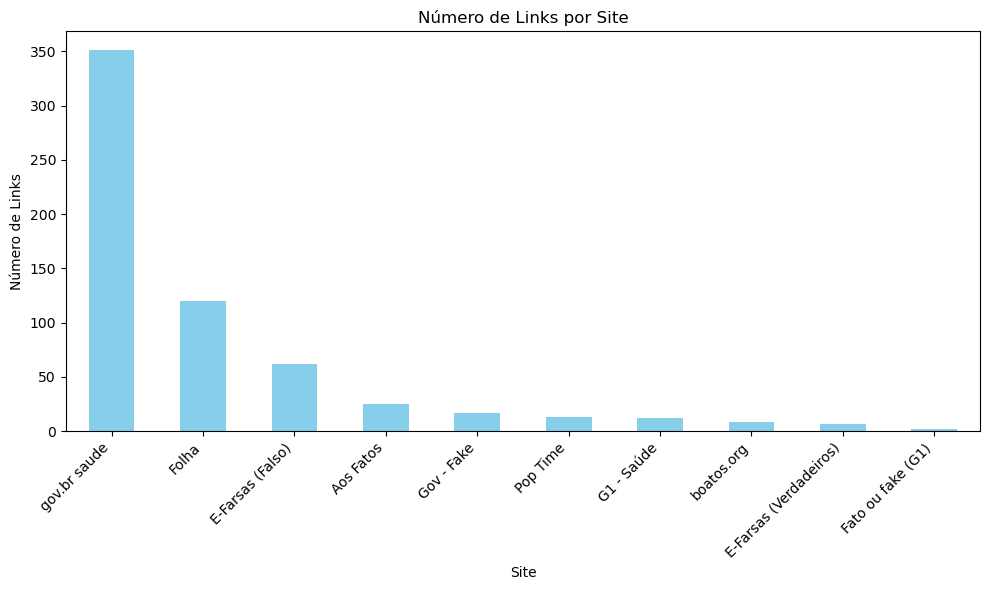

In [42]:
# Contar o número de links para cada site
site_counts = df_combined['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

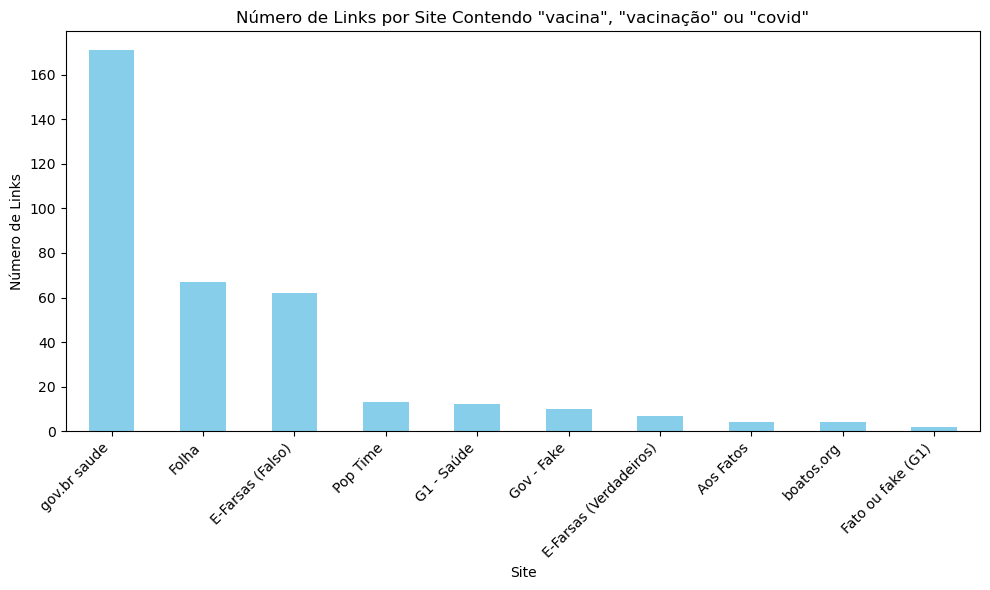

In [43]:
# Filtrar os links que contêm as palavras-chave
filtered_df = df_combined[df_combined['title'].str.contains('|'.join(keywords), case=False, na=False)]

# Contar o número de links para cada site
site_counts = filtered_df['Site'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', color='skyblue')
plt.title('Número de Links por Site Contendo "vacina", "vacinação" ou "covid"')
plt.xlabel('Site')
plt.ylabel('Número de Links')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()

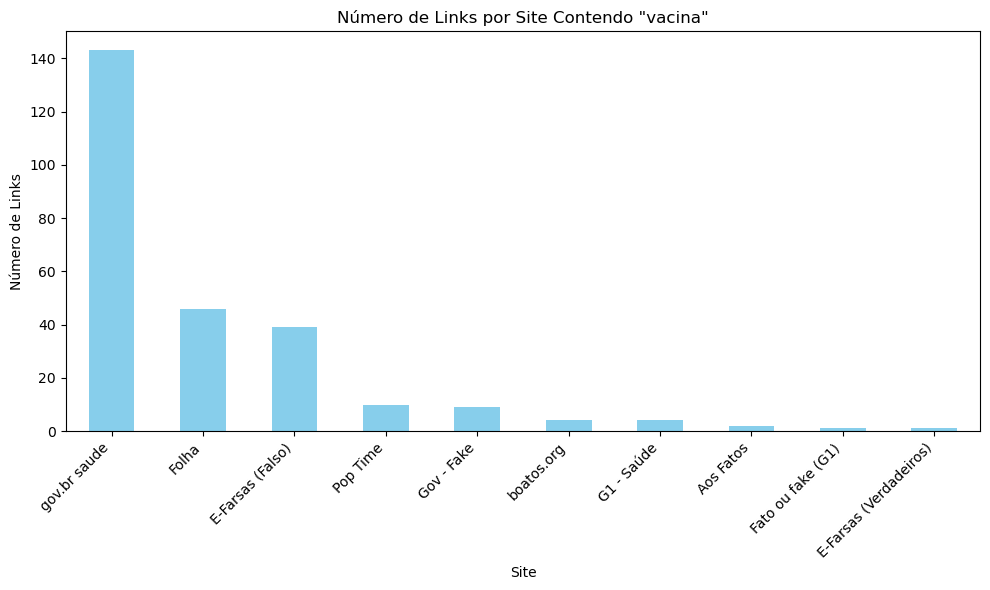

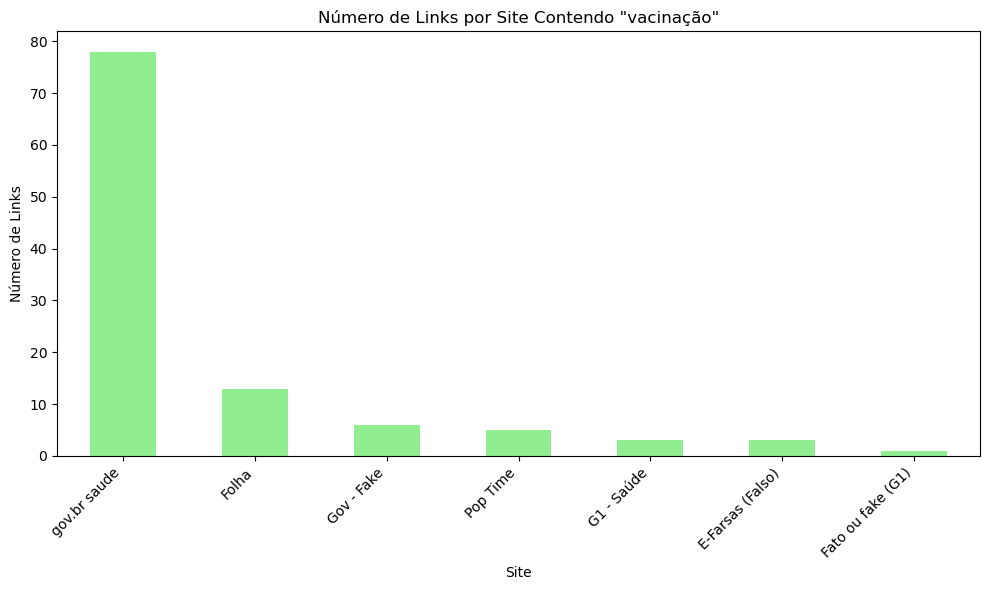

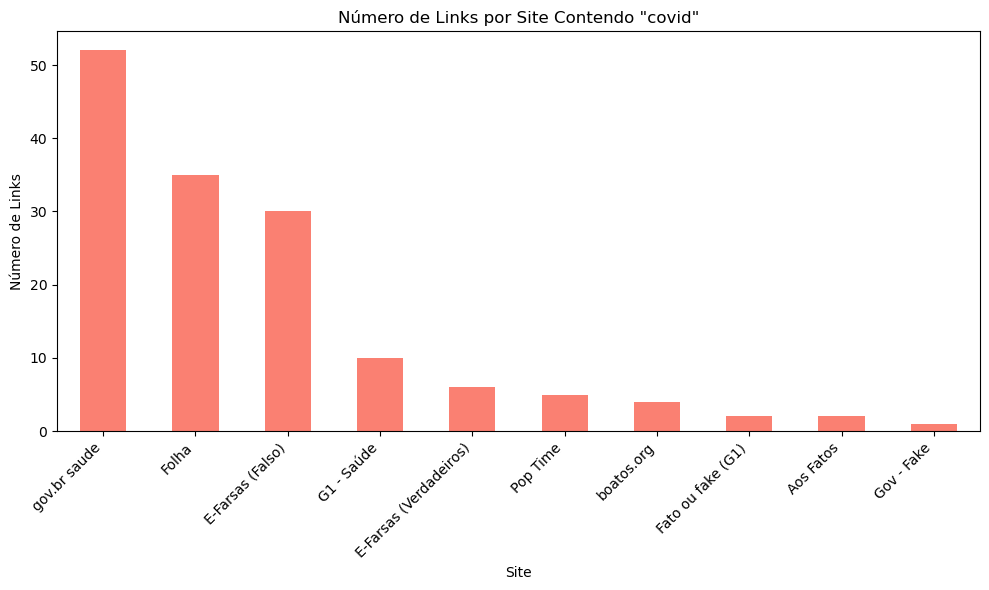

In [44]:
# Gráfico para "vacina"
plot_keyword_distribution(df_combined, "vacina", 'skyblue')

# Gráfico para "vacinação"
plot_keyword_distribution(df_combined, "vacinação", 'lightgreen')

# Gráfico para "covid"
plot_keyword_distribution(df_combined, "covid", 'salmon')